# PIC-16A Mini-Project

Thomas Valles, Adhvaith Vijay

## Group Contribution Statement

Thomas will lead the exploratory analysis and the logistic regression model. Adhvaith complete the decision tree model as well as a K-nearest neighbors model. We will both work on the final discussion

## Exploratory Analysis

In [1]:
import urllib
url = 'https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv'
filedata = urllib.request.urlopen(url)
with open('palmer_penguins.csv', 'wb') as f:
    f.write(filedata.read())

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
penguins = pd.read_csv('palmer_penguins.csv')

penguins['Species'] = penguins['Species'].str.split().str.get(0)

In [4]:
penguins.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


We wish to be able to create a model that can determine a penguin's species based on some of its attributes. Let's first see what the possible species are:

In [5]:
set(penguins['Species'])

{'Adelie', 'Chinstrap', 'Gentoo'}

There are three unique species. Now, let's see what kind of information we have about each penguin:

In [6]:
penguins.columns

Index(['studyName', 'Sample Number', 'Species', 'Region', 'Island', 'Stage',
       'Individual ID', 'Clutch Completion', 'Date Egg', 'Culmen Length (mm)',
       'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex',
       'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Comments'],
      dtype='object')

Columns such as 'studyName', 'Sample Number', 'Stage', 'Individual ID', 'Clutch Completion', 'Date Egg', and 'Comments', probably won't be helpful to us in making a machine learning model that is intended to predict a random penguin's species. Since we hope to be able to apply our model to a random penguin not necessarily from this dataframe, we should focus only on attributes that are measurable, and disregard things like the ID given to the penguin or the name of the study it came from. Delta 15 N and Delta 13 C are measurements of the ratio between different stable isotopes of nitrogen and carbon respectively in the blood of the penguins.

Although it may be tempting to use all of the other columns to train and test our model, this will likely lead to overfitting. Hence, for each model, we will select only three columns (one qualitative- sex, region, or island, and two quantitative) for training and testing. In order to help determine which columns of the data to use, we must visualize the data.

We will first write a function that can group the penguins by species and display average values for other numerical columns. With the resulting table, we hope to be able to see large differences in some of the average values across different columns for the different species. Those columns of the data which vary greatly between species will be most helpful for us in our modelling, as it will make more difficult for our model to be confused by "borderline" penguins.

In [7]:
def penguin_summary_table(group_cols, value_cols):
    '''
    Creates a table grouping the penguins data by group_cols 
    (the rows of the resulting table) and looking at the value_cols
    (the columns of the resulting table). Each cell in the resulting
    table is the average for the group rounded to 2 decimal places
    
    parameters
    -------------
    group_cols: the columns in the penguins data to group by (should be qualitative)
    value_cols: the columns in the penguins data to display in the table (should be quantitative)
    
    return
    -------------
    a dataframe with len(group_cols) rows and len(val_cols) columns
    
    '''
    return penguins.groupby(group_cols)[value_cols].mean().round(2)

Next, we will write a function that will display a scatterplot where the x and y axes are two numerically valued columns from the dataframe. This function is intended to plot the values for various species in different colors on the same axis, allowing us to (hopefully) see how the different clear trends that are different for each species. Scatter plots are helpful for us as each point will represent a penguin. Clear separations in the colors within individual plots will indicate that the columns chosen for the axes of the plot are good candidates to use for our model.

In [8]:
def penguin_scatter(df, value_cols, fig, ax, title):
    '''
    Creates a scatter plot of the penguins dataframe or a subset of it where the 
    x and y axes are determined by the value_cols input
    
    parameters
    ----------------
    df: the data from with which to work with
    value_cols: the 2 columns of the data frame to plot. value_cols[0] will be the x-axis
                value_cols[1] will be the y-axis
    fig, ax: the figure and axis to plot on
    title: the title to give the plot
    '''
    
    if(len(value_cols) != 2):
        raise ValueError('value_cols must contain exactly 2 column names from the dataframe')
        
        
    # set the x and y label appropriately
    ax.set(xlabel = value_cols[0],
           ylabel = value_cols[1])
    
    # make the scatterplot, label being the name of the dataframe
    ax.scatter(df[value_cols[0]], df[value_cols[1]],
              alpha = 0.5, label = df.name)
    
    #show legend and set title
    ax.legend()
    ax.set(title = title)

We will test columns that are likely correlated. First, we will see make a table comparing culmen length and culmen depth for the different species.

In [9]:
penguin_summary_table(['Species'], ['Culmen Length (mm)', 'Culmen Depth (mm)'])

,Culmen Length (mm),Culmen Depth (mm)
Species,,
Adelie,38.79,18.35
Chinstrap,48.83,18.42
Gentoo,47.50,14.98


This looks very promising. Adelie penguins have a much shorter culmen on average than the Chinstrap and Gentoo penguins, and the Gentoo penguins have a much shallower culmen than the other two species. Motivated by these large differences, we will use our scatterplot function to further visualize how culmen length and depth varies across the different species.

""


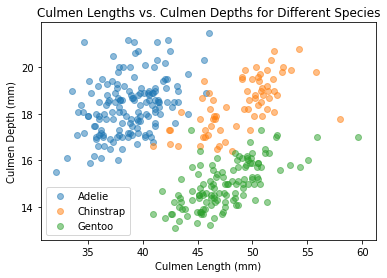

In [10]:
fig, ax = plt.subplots(1)
penguins.groupby(['Species']).apply(penguin_scatter, 
                                    value_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)'],
                                    fig = fig, ax = ax,
                                    title = "Culmen Lengths vs. Culmen Depths for Different Species")

This is great! There is very little overlap between the different species. We will certainly use these two quantitative columns in training and testing our model.

There may be other columns which are also good candidates for our model. Let's test flipper length and body mass.

""


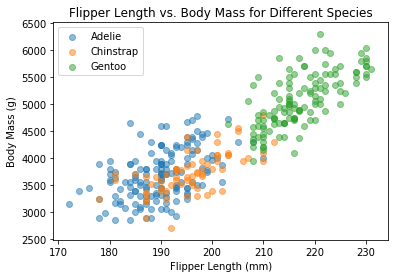

In [11]:
fig, ax = plt.subplots(1)
penguins.groupby(['Species']).apply(penguin_scatter,
                                    value_cols = ['Flipper Length (mm)', 'Body Mass (g)'],
                                    fig = fig, ax = ax,
                                    title = 'Flipper Length vs. Body Mass for Different Species')

There is a clear difference between Gentoo penguins and the other two species in this graph, but the Adelie and Chinstrap points overlap. A model using these columns would probably be very good at identifying Gentoo penguins, but would often confuse Adelie and Chinstrap penguins.

Let's now see how the Delta 15 N and Delta 13 C values vary across the different species.

""


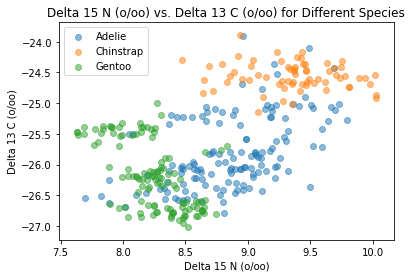

In [12]:
fig, ax = plt.subplots(1)
penguins.groupby(['Species']).apply(penguin_scatter,
                                    value_cols = ['Delta 15 N (o/oo)', 'Delta 13 C (o/oo)'],
                                    fig = fig, ax = ax,
                                    title = 'Delta 15 N (o/oo) vs. Delta 13 C (o/oo) for Different Species')

There are three clear regions, but the Adelie region seems to bleed into the the Chinstrap and Gentoo regions quite a bit. It's certainly better than the "Flipper Length vs. Body Mass" comparison but probably not as good as the "Culmen Length vs. Culmen Depth" comparsion. Still, it may be a good idea to test one of our models using these columns.

## Models

We will consider three models in helping us predict a penguin's speceies based on various attributes.


In [13]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

### Logistic Regression

Let's drop the columns we know we can't use for fitting. Then, we'll drop any nan's in order to get meaningful numerical and qualitative data.

In [14]:
penguins = penguins [['Species', 'Island', 'Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 
                    'Body Mass (g)', 'Sex', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']]
penguins["Species"] = penguins["Species"].str.split().str.get(0)
penguins = penguins.dropna()

Now that we have the subset of the data frame that we'd like to analyze, we can split the data into training and testing sets and do further data prepping. We wish to split the data in this manner to analyze how well our model does with unseen data. We are in a sense turning a blind eye to 20% of the data and using the other 80% to train the model on. Our further data prepping includes transforming the qualitative data (sex, island, species) into numerical values.

In [15]:
# split into training and testing
train, test = train_test_split(penguins, test_size = 0.2)

def prep_penguins_data(data_df):
    '''
    prepares the penguins data for our model by transforming qualitative
    quantities into numerical values and splitting the target and 
    predictor variables
    
    parameters
    ---------------
    data_df: some subset of the penguins dataframe
    
    return
    ---------------
    X: the possible predictor variables (all except species) associated with the input 
    y: the species column of the input
    '''
    df = data_df.copy()
    le = preprocessing.LabelEncoder()
    
    df['Sex'] = le.fit_transform(df['Sex'])
    df['Island'] = le.fit_transform(df['Island'])
    df['Species'] = le.fit_transform(df['Species'])
    
    X = df.drop(['Species'], axis = 1)
    y = df['Species']
        
    return(X, y)

In [16]:
# now split the training and desting data into the predictor and target variables
X_train, y_train = prep_penguins_data(train)
X_test,  y_test  = prep_penguins_data(test)

First, we check the cross validation score on the training data.

In [17]:
LR = LogisticRegression()
cross_val_score(LR, X_train, y_train, cv = 5).mean()

1.0

That's really high, but we used all the columns in this model. We may have overfit. Let's limit ourselves to three columns.

We have already identified some potential candidate quantitative columns in our exploratory analysis, but we don't know a third column to use in conjunction with the culmen length and culmen depth. Let's write a function which can determine the best columns to use based on an input model and training data. Cross validation is helpful here because it allows for our model to be trained and tested on subsets of our training data. Since we are training and testing over many different subsets of the data and taking the mean, we are getting a better sense of the true performance of the model. 

In [18]:
def find_best_cols(model, X_train, y_train, combos):
    '''
    Determines the best combination of columns to use for the model using cross validation
    
    parameters
    ----------------
    model: to machine learning model to use
    X_train, y_train: the predictor and target variables for the model
    combos: the columns of X_train to search over 
    
    return
    ----------------
    best_cols: the columns from combos that achieved the best cross validation score
    best_score: the score those columns achieved
    '''
    
    # initialize best score, best cols
    best_score = 0
    best_cols = []
    # loop through al columns
    for cols in combos: 
        x = cross_val_score(model, X_train[cols], y_train, cv = 5).mean()
        # if we've found a better set, update
        if x > best_score:
            best_score = x
            best_cols = cols
    return best_cols, best_score

We will check subsets of the columns that include culmen length and culmen depth.

In [19]:
# get all the columns
possible_cols = list(X_train.columns)
# drop the two we know we'll be using for sure
possible_cols.remove('Culmen Length (mm)')
possible_cols.remove('Culmen Depth (mm)')

# populate the columns to test with culmen length, depth, and the third other column
subsets = [['Culmen Length (mm)', 'Culmen Depth (mm)', col] for col in possible_cols]

#call our function
best_cols, best_score = find_best_cols(LR, X_train, y_train, subsets)
print("The best CV score was " + str(best_score) + " which was attained when using the columns: " + str(best_cols))

The best CV score was 0.9923076923076923 which was attained when using the columns: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 15 N (o/oo)']


Now that we've determined the best columns, let's figure out the best inverse regulation strength $C$. We'll try values from 0-3.

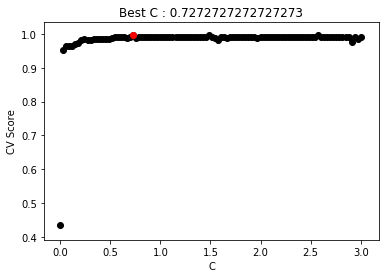

In [20]:
fig, ax = plt.subplots(1)

best_score = 0
best_c = 0

# c_vals from 0-10
c_vals = np.linspace(0, 3, 100)

# loop through possible c_vals
for c_val in c_vals:
    
    # evaluate the model with the current c_val
    LR = LogisticRegression(C = c_val)
    cv_score = cross_val_score(LR, X_train[best_cols], y_train, cv=5).mean()
    ax.scatter(c_val, cv_score, color = "black")
    
    # check if we've beaten our previous score
    if cv_score > best_score:
        best_c = c_val
        best_score = cv_score

l = ax.set(title = "Best C : " + str(best_c),
       xlabel = "C", 
       ylabel = "CV Score")
ax.scatter(best_c, best_score, color = "red")

It seems that for $C$ values greater than ~0.3, the CV scores are pretty close. 

Let's see how our model performs on the test data.

In [21]:
LR = LogisticRegression(C = best_c)
LR.fit(X_train[best_cols], y_train)
LR.score(X_test[best_cols], y_test)

0.9846153846153847

98%, not bad!

### Evaluation of Logistic Regression
We will now evaluate our model by seeing where it went wrong using the confusion matrix and by looking at a plot which displays the different regions of predictions our model produced.

Our penguins species have been mapped to integers in the following way: 

Adelie -> 0

Chinstrap -> 1

Gentoo -> 2

In [22]:
# creating a new datafram that will easily display the predicted and actual values
y_results = pd.DataFrame(y_test)

# adding another column to y_test that indicates the predicted value
y_results['Predicted'] = LR.predict(X_test[best_cols])
# the predicted values using the testing data
c = confusion_matrix(y_results['Species'], y_results['Predicted'])
c

array([[25,  1,  0],
       [ 0, 11,  0],
       [ 0,  0, 28]], dtype=int64)

Looks like we were wrong with only one penguin.

In [23]:
# the mistakes are when the actual species was not the predicted species
mistakes = y_results[y_results['Species'] != y_results['Predicted']]
mistakes

,Species,Predicted
129,0,1


Before we look at the specific mistakes, let's remind ourselves of what the graph of culmen length vs. culmen depth for different species looked like:

""


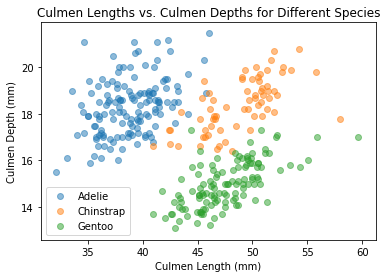

In [24]:
fig, ax = plt.subplots(1)
penguins.groupby(['Species']).apply(penguin_scatter, 
                                    value_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)'],
                                    fig = fig, ax = ax,
                                    title = "Culmen Lengths vs. Culmen Depths for Different Species")

Our one mistake was with penguin 129. The model predicted it was a Chinstrap when it was really an Adelie.

In [29]:
penguins.loc[129]

Species                   Adelie
Island                 Torgersen
Culmen Length (mm)          44.1
Culmen Depth (mm)             18
Flipper Length (mm)          210
Body Mass (g)               4000
Sex                         MALE
Delta 15 N (o/oo)        9.10702
Delta 13 C (o/oo)       -26.0136
Name: 129, dtype: object

It's easy to see why the model made this mistake. This specific penguin has a rather shallow culmen for it's culmen length. Most Adelie penguins with a culmen length of around 44mm have a culmen depth more much than 18mm. We can also see a lot of blue/orange overlap in the area of the graph around (44, 18).

Let's now take a look at the decision regions for our logistic regression model.

In [27]:
# X_male = X_test[X_test['Sex'] == 1]
# y_male = y_test[X_test['Sex'] == 1]
# X_female = X_test[X_test['Sex'] == 0]
# y_female = y_test[X_test['Sex'] == 0]


# plot_regions(LR, X_train, y_train,
#              X_male, y_male, 
#              ['Culmen Length (mm)', 'Culmen Depth (mm)'],
#              "Male")


In [28]:
# plot_regions(LR, X_train, y_train,
#              X_female, y_female, 
#              ['Culmen Length (mm)', 'Culmen Depth (mm)'],
#              "Female")